In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import ast

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
df = pd.read_csv('/kaggle/input/issues/issues.csv')

# Columns selection

In [3]:
df.columns

Index(['url', 'repository_url', 'labels_url', 'comments_url', 'events_url',
       'html_url', 'id', 'node_id', 'number', 'title', 'user', 'labels',
       'state', 'locked', 'assignee', 'assignees', 'milestone', 'comments',
       'created_at', 'updated_at', 'closed_at', 'author_association',
       'active_lock_reason', 'draft', 'pull_request', 'body', 'reactions',
       'timeline_url', 'performed_via_github_app', 'state_reason'],
      dtype='object')

In [4]:
issues_columns = ['url', 'number', 'title', 'user', 'labels', 'comments', 'created_at', 'updated_at', 'closed_at',  'author_association', 'body', 'reactions', ]

In [5]:
df = df[issues_columns]

# User column cleaning

In [6]:
df[['user']].iloc[0]['user']

"{'login': 'hachi8833', 'id': 4289625, 'node_id': 'MDQ6VXNlcjQyODk2MjU=', 'avatar_url': 'https://avatars.githubusercontent.com/u/4289625?v=4', 'gravatar_id': '', 'url': 'https://api.github.com/users/hachi8833', 'html_url': 'https://github.com/hachi8833', 'followers_url': 'https://api.github.com/users/hachi8833/followers', 'following_url': 'https://api.github.com/users/hachi8833/following{/other_user}', 'gists_url': 'https://api.github.com/users/hachi8833/gists{/gist_id}', 'starred_url': 'https://api.github.com/users/hachi8833/starred{/owner}{/repo}', 'subscriptions_url': 'https://api.github.com/users/hachi8833/subscriptions', 'organizations_url': 'https://api.github.com/users/hachi8833/orgs', 'repos_url': 'https://api.github.com/users/hachi8833/repos', 'events_url': 'https://api.github.com/users/hachi8833/events{/privacy}', 'received_events_url': 'https://api.github.com/users/hachi8833/received_events', 'type': 'User', 'site_admin': False}"

In [8]:
# Convert the 'user' column from string to a Python dictionary
df['user'] = df['user'].apply(ast.literal_eval)

# Define a function to extract the 'login' key from the user dictionary
def get_username(x):
    return x['login']

# Create a new 'username' column in the DataFrame by applying the 'get_username' function
df['username'] = df['user'].apply(get_username)

/tmp/ipykernel_28/3031153136.py:10: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly_counts = df.groupby(df['created_at'].dt.to_period('M')).size()


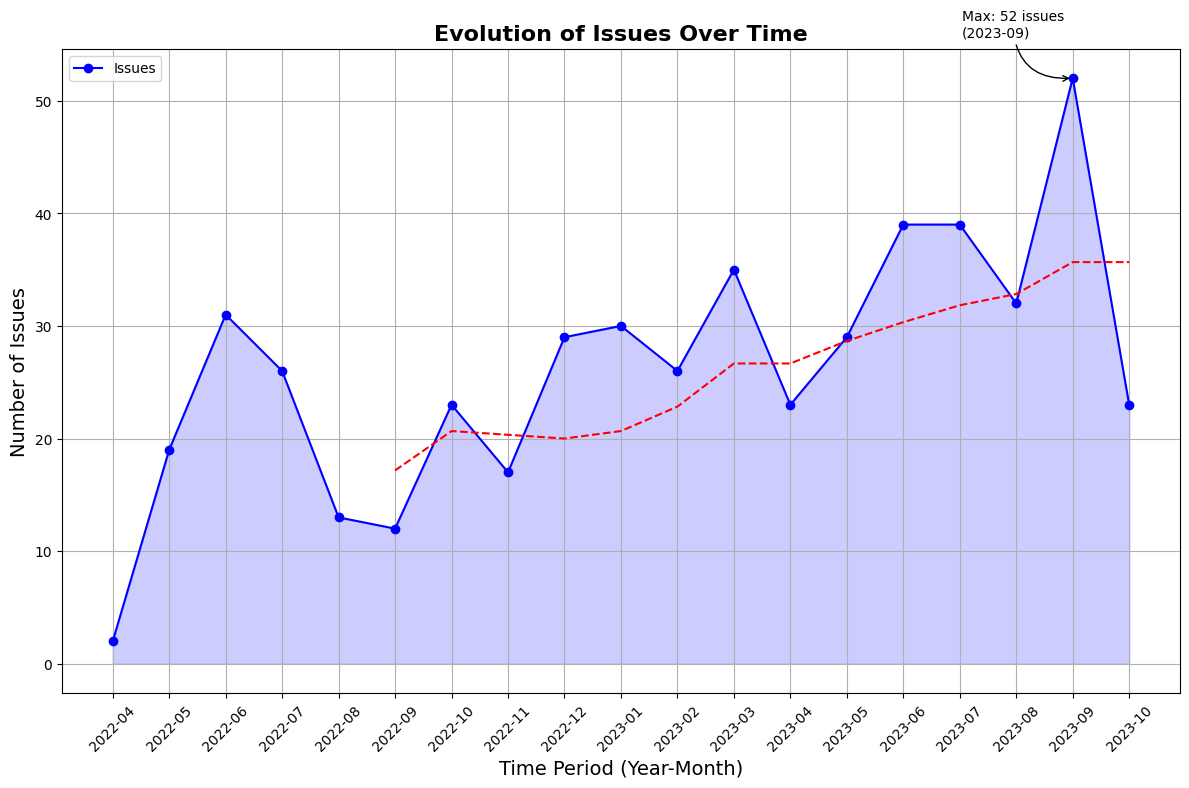

In [11]:


# Convert 'created_at' column to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Group issues by month and count them
monthly_counts = df.groupby(df['created_at'].dt.to_period('M')).size()

# Convert Period index to string for plotting
monthly_counts.index = monthly_counts.index.strftime('%Y-%m')

# Create a time series plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # Include day of the month
plt.xticks(rotation=45)
plt.xlabel('Time Period (Year-Month)', fontsize=14)
plt.ylabel('Number of Issues', fontsize=14)
plt.title('Evolution of Issues Over Time', fontsize=16, fontweight='bold')

# Customize the appearance of the plot
plt.plot(monthly_counts.index, monthly_counts.values, marker='o', linestyle='-', color='b', label='Issues')
plt.fill_between(monthly_counts.index, monthly_counts.values, alpha=0.2, color='b')

# Add gridlines and legend
plt.grid(True)
plt.legend(loc='upper left')

# Add annotations for important points (e.g., peaks)
max_count = max(monthly_counts)
max_date = monthly_counts.idxmax()
plt.annotate(f'Max: {max_count} issues\n({max_date})', xy=(max_date, max_count),
             xytext=(-80, 30), textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'))

# Show a smoother trendline (optional)
smoothed_counts = monthly_counts.rolling(window=6).mean()
plt.plot(monthly_counts.index, smoothed_counts.values, linestyle='--', color='r', label='Smoothed Trend')

# Set custom x-axis labels (remove day of the month)
custom_xticks = monthly_counts.index
custom_xticklabels = [date.split('-')[0] + '-' + date.split('-')[1] for date in custom_xticks]
ax.set_xticks(custom_xticks)
ax.set_xticklabels(custom_xticklabels, rotation=45)

plt.tight_layout()
plt.show()


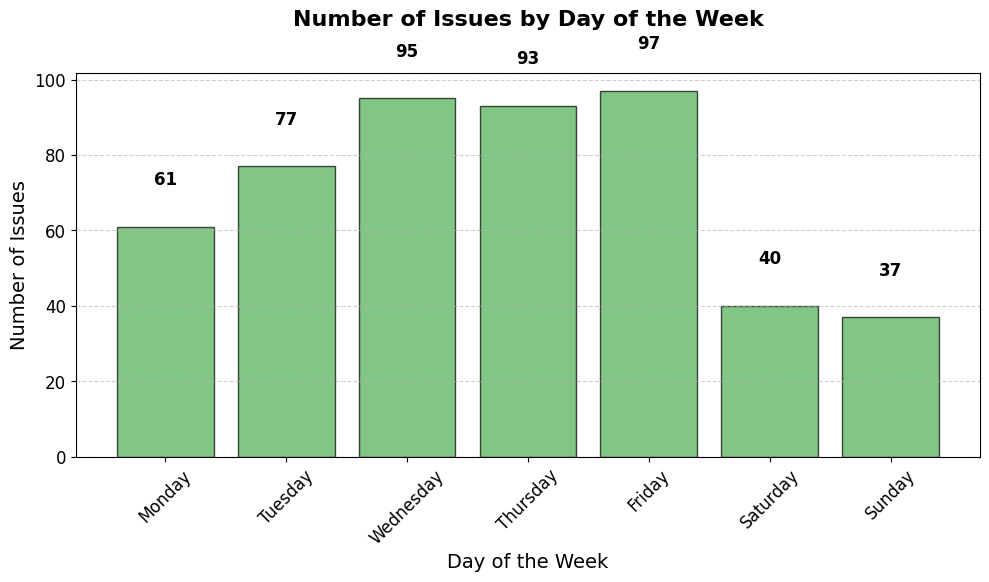

In [12]:

# Extract the day of the week
df['day_of_week'] = df['created_at'].dt.dayofweek

# Group issues by day of the week and count them
day_of_week_counts = df['day_of_week'].value_counts().sort_index()

# Define day names for labeling the x-axis
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a visually appealing bar chart
plt.figure(figsize=(10, 6))
plt.bar(day_names, day_of_week_counts, color='#4CAF50', alpha=0.7, edgecolor='black')

# Add data labels on top of the bars
for i, count in enumerate(day_of_week_counts):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Number of Issues', fontsize=14)
plt.title('Number of Issues by Day of the Week', fontsize=16, fontweight='bold', y=1.1)  # Adjust 'y' parameter
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


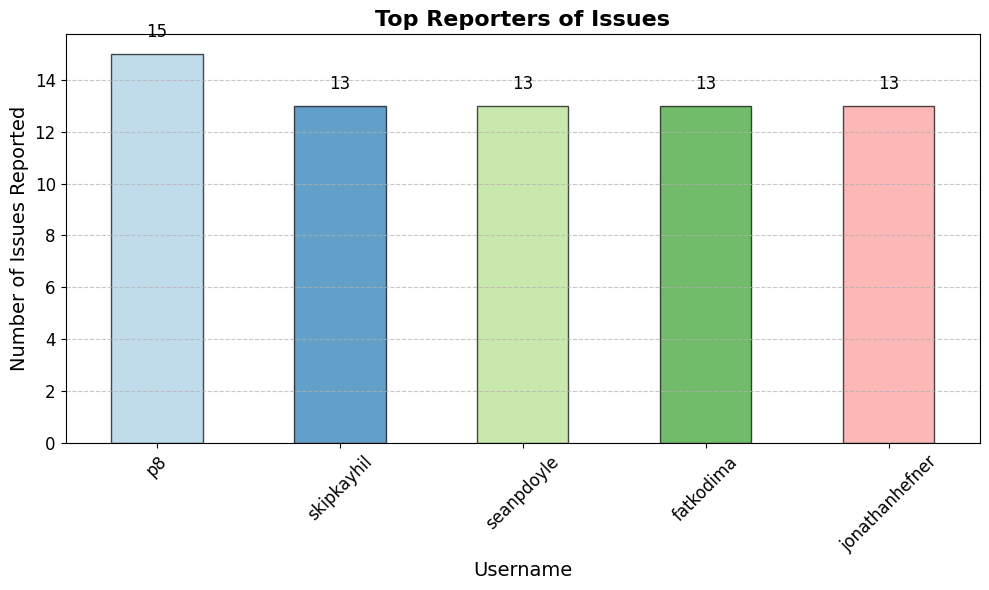

In [14]:

# Group issues by username and count them
reporter_counts = df['username'].value_counts()

# Identify top reporters
top_reporters = reporter_counts.head(5)  # Adjust the number as needed

# Create a more sophisticated bar chart
plt.figure(figsize=(10, 6))
colors = plt.cm.Paired(range(len(top_reporters)))

top_reporters.plot(kind='bar', color=colors, edgecolor='k', linewidth=1, alpha=0.7)
plt.title('Top Reporters of Issues', fontsize=16, fontweight='bold')
plt.xlabel('Username', fontsize=14)
plt.ylabel('Number of Issues Reported', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add data labels
for i, v in enumerate(top_reporters):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=12)

# Customize the gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


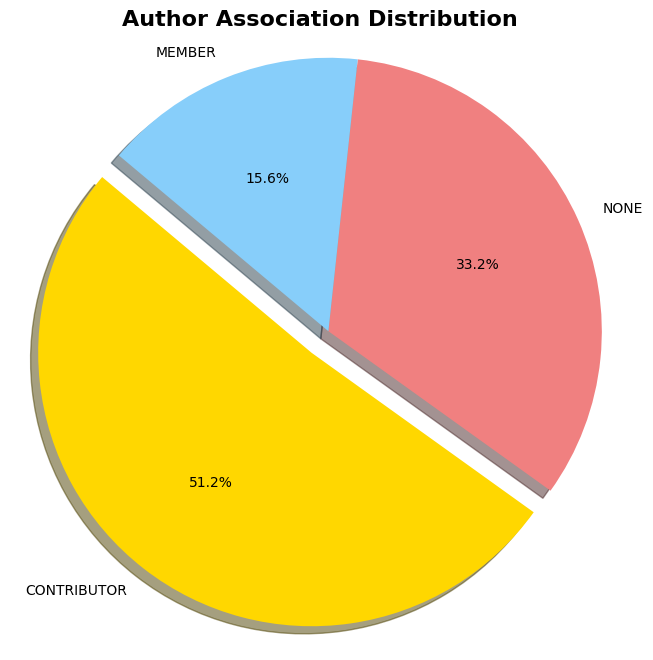

In [15]:
# Count the occurrences of each author association
author_association_counts = df['author_association'].value_counts()

# Create a pie chart
plt.figure(figsize=(8, 8))
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen']

# Manually create explode values
explode = [0.1 if label == 'CONTRIBUTOR' else 0 for label in author_association_counts.index]

plt.pie(author_association_counts, labels=author_association_counts.index, autopct='%1.1f%%',
        colors=colors, explode=explode, shadow=True, startangle=140)

plt.title('Author Association Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

plt.show()

In [16]:
df['labels']

0      [{'id': 150377, 'node_id': 'MDU6TGFiZWwxNTAzNz...
1      [{'id': 107194, 'node_id': 'MDU6TGFiZWwxMDcxOT...
2      [{'id': 107195, 'node_id': 'MDU6TGFiZWwxMDcxOT...
3      [{'id': 107191, 'node_id': 'MDU6TGFiZWwxMDcxOT...
4      [{'id': 107191, 'node_id': 'MDU6TGFiZWwxMDcxOT...
                             ...                        
495    [{'id': 107191, 'node_id': 'MDU6TGFiZWwxMDcxOT...
496    [{'id': 107188, 'node_id': 'MDU6TGFiZWwxMDcxOD...
497    [{'id': 664533972, 'node_id': 'MDU6TGFiZWw2NjQ...
498    [{'id': 107189, 'node_id': 'MDU6TGFiZWwxMDcxOD...
499    [{'id': 107189, 'node_id': 'MDU6TGFiZWwxMDcxOD...
Name: labels, Length: 500, dtype: object

In [17]:
# Create an empty set to store unique labels
labels = set()

# Convert the 'labels' column from string to a Python list of dictionaries
df['labels'] = df['labels'].apply(ast.literal_eval)

# Iterate through each row in the DataFrame
for index, row in df.iterrows():
    # Extract labels from the 'labels' column and add them to the 'labels' set
    for e in df['labels'].iloc[index]:
        labels.add(e.get("name"))

# Create new columns in the DataFrame for each unique label and initialize them with 0
for label in labels:
    df[label] = 0

# Iterate through each row in the DataFrame again
for index, row in df.iterrows():
    # Check if a label exists in the 'labels' list and set the corresponding column to 1
    for e in row['labels']:
        if 'name' in e:
            df.loc[index, e.get("name")] = 1


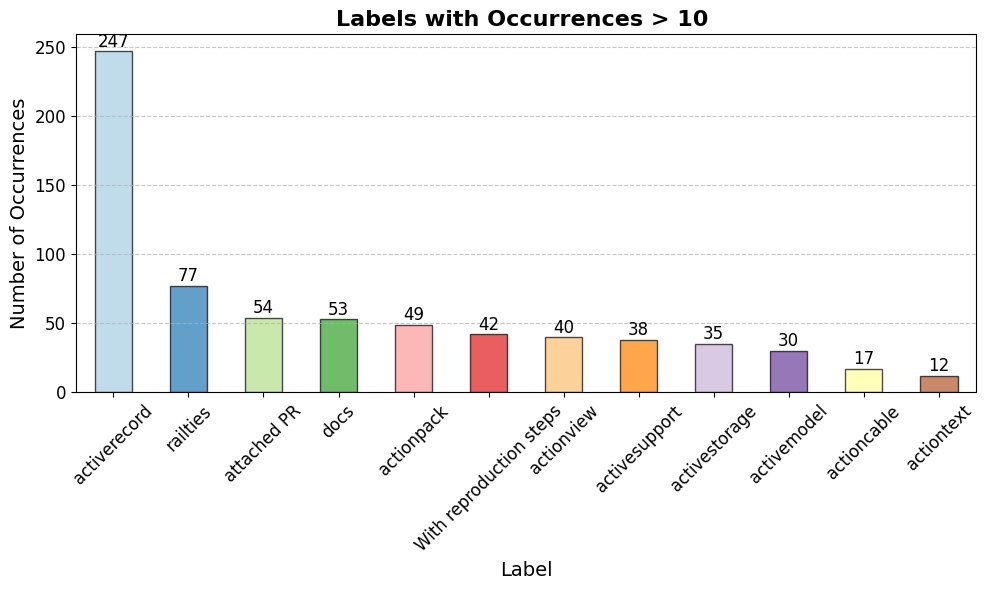

In [18]:
# Select only the label columns
label_columns = df[list(labels)]

# Sum each label column to count the occurrences
label_counts = label_columns.sum()

# Filter labels with occurrences greater than 10
popular_labels = label_counts[label_counts > 10]

# Sort the labels in decreasing order by count
popular_labels_sorted = popular_labels.sort_values(ascending=False)

# Create a more sophisticated bar chart for popular labels
plt.figure(figsize=(10, 6))
colors = plt.cm.Paired(range(len(popular_labels_sorted)))

popular_labels_sorted.plot(kind='bar', color=colors, edgecolor='k', linewidth=1, alpha=0.7)
plt.title('Labels with Occurrences > 10 ', fontsize=16, fontweight='bold')
plt.xlabel('Label', fontsize=14)
plt.ylabel('Number of Occurrences', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add data labels
for i, v in enumerate(popular_labels_sorted):
    plt.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=12)

# Customize the gridlines
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Data Preparation and Dataset Creation for Multi-Label Classification

In [24]:
# Select the top 5 popular labels
labels = list(popular_labels_sorted.index[:5])

# Extract issue descriptions as a numpy array
descriptions = df.body.to_numpy()

# Extract the target labels (binary indicators for the selected labels)
target = df[list(labels)].to_numpy()

# Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(descriptions, target, test_size=0.2, random_state=42)

# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.encodings = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

# Create dataloaders
train_dataset = CustomDataset(list(train_texts), train_labels, tokenizer)
val_dataset = CustomDataset(list(val_texts), val_labels, tokenizer)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
#BERT architecture

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels))
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# BERT Training

In [54]:

# Load the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(labels))
model = model.to('cuda')  # Move the model to GPU

# Fine-tune the model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits for multi-label
epochs = 50
for epoch in range(epochs):  
    print('****************')
    print(f'Epoch {epoch + 1}')
    
    model.train()
    total_train_loss = 0.0  # Initialize total training loss
    
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        targets = batch['labels'].to('cuda')
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    average_train_loss = total_train_loss / len(train_dataloader)
    print(f'Training Loss (Epoch): {average_train_loss:.4f}')
    
    # Evaluate the model on the validation set
    model.eval()
    total_val_loss = 0.0  # Initialize total validation loss
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            targets = batch['labels'].to('cuda')
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            val_loss = criterion(logits, targets)
            total_val_loss += val_loss.item()

    average_val_loss = total_val_loss / len(val_dataloader)
    print(f'Validation Loss: {average_val_loss:.4f}')

# End of training
print('Training completed!')


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


****************
Epoch 1
Training Loss (Epoch): 0.5494
Validation Loss: 0.4642
****************
Epoch 2
Training Loss (Epoch): 0.4484
Validation Loss: 0.4277
****************
Epoch 3
Training Loss (Epoch): 0.4230
Validation Loss: 0.4095
****************
Epoch 4
Training Loss (Epoch): 0.4106
Validation Loss: 0.4020
****************
Epoch 5
Training Loss (Epoch): 0.3915
Validation Loss: 0.3881
****************
Epoch 6
Training Loss (Epoch): 0.3683
Validation Loss: 0.3837
****************
Epoch 7
Training Loss (Epoch): 0.3422
Validation Loss: 0.3741
****************
Epoch 8
Training Loss (Epoch): 0.3180
Validation Loss: 0.3758
****************
Epoch 9
Training Loss (Epoch): 0.2972
Validation Loss: 0.3705
****************
Epoch 10
Training Loss (Epoch): 0.2776
Validation Loss: 0.3693
****************
Epoch 11
Training Loss (Epoch): 0.2611
Validation Loss: 0.3764
****************
Epoch 12
Training Loss (Epoch): 0.2478
Validation Loss: 0.3738
****************
Epoch 13
Training Loss (Epoch): 

In [55]:
# Evaluate the model on the validation set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        targets = batch['labels'].to('cuda')
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.tolist())
        true_labels.extend(targets.tolist())

# Convert predictions and true_labels to NumPy arrays
import numpy as np
predicted_labels = np.array(predictions)
true_labels = np.array(true_labels)

# Threshold the predicted labels
threshold = 0.5  #
predicted_labels = (predicted_labels > threshold).astype(int)

# Import classification report
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=list(labels))

print(report)


              precision    recall  f1-score   support

activerecord       0.70      0.79      0.75        48
    railties       0.29      0.15      0.20        13
 attached PR       0.17      0.11      0.13         9
        docs       1.00      0.13      0.24        15
  actionpack       1.00      0.22      0.36         9

   micro avg       0.63      0.48      0.55        94
   macro avg       0.63      0.28      0.34        94
weighted avg       0.67      0.48      0.49        94
 samples avg       0.42      0.39      0.39        94



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# DistilBert Training

In [27]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(labels))
#DistilBert Architecture
model

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [56]:


model = model.to('cuda')  # Move the model to GPU

# Fine-tune the model
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy with Logits for multi-label
epochs = 50

for epoch in range(epochs): 
    print('****************')
    print(f'Epoch {epoch + 1}')
    
    model.train()
    total_train_loss = 0.0  # Initialize total training loss
    
    for batch in train_dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        targets = batch['labels'].to('cuda')
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    average_train_loss = total_train_loss / len(train_dataloader)
    print(f'Training Loss (Epoch): {average_train_loss:.4f}')
    
    # Evaluate the model on the validation set
    model.eval()
    total_val_loss = 0.0  # Initialize total validation loss
    
    with torch.no_grad():
        for batch in val_dataloader:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            targets = batch['labels'].to('cuda')
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            val_loss = criterion(logits, targets)
            total_val_loss += val_loss.item()

    average_val_loss = total_val_loss / len(val_dataloader)
    print(f'Validation Loss: {average_val_loss:.4f}')

# End of training
print('Training completed!')


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


****************
Epoch 1
Training Loss (Epoch): 0.5833
Validation Loss: 0.4833
****************
Epoch 2
Training Loss (Epoch): 0.4600
Validation Loss: 0.4307
****************
Epoch 3
Training Loss (Epoch): 0.4337
Validation Loss: 0.4182
****************
Epoch 4
Training Loss (Epoch): 0.4220
Validation Loss: 0.4152
****************
Epoch 5
Training Loss (Epoch): 0.4113
Validation Loss: 0.4156
****************
Epoch 6
Training Loss (Epoch): 0.3989
Validation Loss: 0.4068
****************
Epoch 7
Training Loss (Epoch): 0.3778
Validation Loss: 0.3917
****************
Epoch 8
Training Loss (Epoch): 0.3518
Validation Loss: 0.3940
****************
Epoch 9
Training Loss (Epoch): 0.3244
Validation Loss: 0.3793
****************
Epoch 10
Training Loss (Epoch): 0.3038
Validation Loss: 0.3868
****************
Epoch 11
Training Loss (Epoch): 0.2919
Validation Loss: 0.3717
****************
Epoch 12
Training Loss (Epoch): 0.2717
Validation Loss: 0.3797
****************
Epoch 13
Training Loss (Epoch): 

In [57]:
# Evaluate the model on the validation set
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in val_dataloader:
        input_ids = batch['input_ids'].to('cuda')
        attention_mask = batch['attention_mask'].to('cuda')
        targets = batch['labels'].to('cuda')
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions.extend(logits.tolist())
        true_labels.extend(targets.tolist())

# Convert predictions and true_labels to NumPy arrays
import numpy as np
predicted_labels = np.array(predictions)
true_labels = np.array(true_labels)

# Threshold the predicted labels 
threshold = 0.5  # 
predicted_labels = (predicted_labels > threshold).astype(int)

# Import classification report
from sklearn.metrics import classification_report

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=list(labels))

print(report)


              precision    recall  f1-score   support

activerecord       0.67      0.88      0.76        48
    railties       0.20      0.08      0.11        13
 attached PR       0.33      0.11      0.17         9
        docs       1.00      0.07      0.12        15
  actionpack       0.00      0.00      0.00         9

   micro avg       0.61      0.48      0.54        94
   macro avg       0.44      0.23      0.23        94
weighted avg       0.56      0.48      0.44        94
 samples avg       0.42      0.38      0.39        94



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
